## 📦 [데이터셋] 전자상거래 배송 데이터 (Customer Analytics)

본 데이터셋은 국제 전자상거래 업체의 고객 데이터로, **제품 배송의 정시 도착 여부**를 분석하고 예측하기 위한 목적으로 구성되었습니다.

### 1. 타겟 변수 (Target Variable)
* **Reached.on.Time_Y.N**: 제품의 정시 도착 여부
    * **1**: 지연 도착 (Delayed)
    * **0**: 정시 도착 (On Time)

---

### 2. 데이터 컬럼 상세 설명 (Features)

| 컬럼명 | 설명 | 데이터 타입 | 비고 (Perspective) |
| :--- | :--- | :--- | :--- |
| **ID** | 고객 고유 식별 번호 | Integer | 예측 모델 구축 시 제거 대상 |
| **Warehouse_block** | 창고 구역 (A, B, C, D, E) | Object | 구역별 물류 부하 및 병목 현상 확인 |
| **Mode_of_Shipment** | 배송 수단 (Ship, Flight, Road) | Object | 수단별 지연율(지연 비중) 분석의 핵심 |
| **Customer_care_calls** | 고객 센터 문의 전화 횟수 | Integer | 배송 지연에 따른 고객 불만 척도 |
| **Customer_rating** | 고객 만족도 점수 (1~5) | Integer | 지연 여부와 만족도의 상관관계 분석 |
| **Cost_of_the_Product** | 제품 가격 (USD) | Integer | 고가 제품의 우선 배송 여부 확인 |
| **Prior_purchases** | 이전 구매 횟수 | Integer | 충성 고객 대상 배송 서비스 수준 확인 |
| **Product_importance** | 제품 중요도 (low, med, high) | Object | 중요도에 따른 배송 지연 차이 존재 여부 |
| **Gender** | 고객 성별 (F, M) | Object | 성별에 따른 구매 패턴 차이 확인 |
| **Discount_offered** | 할인 금액 | Integer | **핵심 가설:** 할인 폭이 크면 주문 폭주로 지연 가능성 높음 |
| **Weight_in_gms** | 제품 무게 (g) | Integer | 무게에 따른 배송 수단 제한 및 지연 영향 |

---

### 3. 분석 전략 (Initial Strategy)

1. **데이터 정제:** ID 컬럼 삭제 및 범주형 변수(Warehouse, Mode 등) 수치화.
2. **핵심 가설 검증:** - 할인(`Discount_offered`)과 배송 지연(`1`)의 상관관계 분석.
   - 제품 무게(`Weight_in_gms`)가 배송 수단별 지연에 미치는 영향 분석.
3. **성능 지표:** 모델의 예측 성능은 **ROC-AUC** 점수를 기준으로 평가함.

## 0. 데이터 불러오기, 기본 코드

In [ ]:
#!/bin/bash
# !kaggle datasets download prachi13/customer-analytics

In [1]:
#import zipfile
import os

HOME = os.getcwd()
HOME

# zip_file_path = 'customer-analytics.zip'

# extract_to_path = 'data'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_path)

'c:\\Users\\min2m\\github\\project\\E-commerce\\KHM'

In [2]:
import platform
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 분할 및 하이퍼파라미터 튜닝
from sklearn.model_selection import train_test_split, GridSearchCV

# 데이터 전처리 및 성능 평가 지표
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    classification_report
)

# 머신러닝 알고리즘 (부스팅, 앙상블 등)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# 1. 환경 설정 및 경고 무시
# ---------------------------------------------------------
warnings.filterwarnings('ignore') # 모든 FutureWarning 및 경고 무시

# 2. 한글 폰트 설정 (OS별 대응)
# ---------------------------------------------------------
if platform.system() == 'Darwin':     # 맥(macOS)
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

In [7]:
Train = pd.read_csv('data/train_df.csv')
test = pd.read_csv('data/test_df.csv')

Train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,7921,D,Road,4,1,261,2,medium,F,9,4158,0
1,1530,F,Ship,3,3,162,2,low,F,26,1659,1
2,10522,B,Ship,3,2,221,2,medium,M,9,4466,0
3,9559,D,Ship,3,5,157,4,medium,F,2,4640,0
4,969,A,Flight,2,5,272,2,low,M,24,3638,1


## 검증용 데이터 분리

In [22]:
# 1. stratify 옵션을 써서 정답(Reached.on.Time_Y.N) 비율을 유지하며 8:2로 나눕니다.
# 이 함수는 내부적으로 데이터를 랜덤하게 섞어주기 때문에 sample을 따로 안 써도 됩니다.
part1, part2 = train_test_split(Train, 
                                test_size=0.2, 
                                random_state=42, 
                                stratify=Train['Reached.on.Time_Y.N'])

# 2. 각각 파일로 저장
part1.to_csv('data/train_df.csv', index=False)
part2.to_csv('data/test_df.csv', index=False)

print("데이터 분할 및 저장 완료!")
print(f"학습용: {part1.shape}, 테스트용: {part2.shape}")

데이터 분할 및 저장 완료!
학습용: (5631, 12), 테스트용: (1408, 12)


In [23]:
Train = pd.read_csv('data/train_df.csv')
test = pd.read_csv('data/test_df.csv')

Train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,5278,B,Ship,5,1,279,4,low,F,3,1499,0
1,2297,C,Ship,5,1,194,3,medium,F,32,3003,1
2,5265,A,Ship,6,1,304,4,low,F,4,1236,1
3,6660,F,Ship,5,3,224,4,low,M,7,4553,0
4,3973,D,Flight,4,1,180,3,high,F,5,4346,0


In [24]:
print(Train.columns)

Index(['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N'],
      dtype='object')


## 데이터 확인

In [13]:
# [1-1] 전체적인 구조와 결측치 확인
print("--- 🩺 데이터 기본 정보 ---")
print(Train.info())

# [1-2] 수치형 데이터의 통계적 분포 (평균, 최소/최대 등)
print("\n--- 📊 수치형 데이터 요약 통계 ---")
display(Train.describe())

--- 🩺 데이터 기본 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8799 non-null   int64 
 1   Warehouse_block      8799 non-null   object
 2   Mode_of_Shipment     8799 non-null   object
 3   Customer_care_calls  8799 non-null   int64 
 4   Customer_rating      8799 non-null   int64 
 5   Cost_of_the_Product  8799 non-null   int64 
 6   Prior_purchases      8799 non-null   int64 
 7   Product_importance   8799 non-null   object
 8   Gender               8799 non-null   object
 9   Discount_offered     8799 non-null   int64 
 10  Weight_in_gms        8799 non-null   int64 
 11  Reached.on.Time_Y.N  8799 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 825.0+ KB
None

--- 📊 수치형 데이터 요약 통계 ---


,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000
mean,5474.369815,4.049096,2.997386,210.230367,3.581998,13.366974,3631.227867,0.596659
std,3173.326150,1.138649,1.411194,48.051317,1.532722,16.147015,1634.180615,0.490596
min,1.000000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2713.500000,3.000000,2.000000,170.000000,3.000000,4.000000,1838.000000,0.000000
50%,5470.000000,4.000000,3.000000,214.000000,3.000000,7.000000,4140.000000,1.000000
75%,8201.500000,5.000000,4.000000,251.000000,4.000000,10.000000,5045.000000,1.000000
max,10999.000000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [ ]:
# 범주형 변수 분석 : 글자로 된 변수들은 '개수'와 '지연율'을 보는 게 핵심
# 반복되는 분석은 반복문(for)으로 깔끔하게!
cat_features = ['Warehouse_block', 'Mode_of_Shipment', 'Gender', 'Product_importance']

for col in cat_features:
    print(f"\n🔍 [{col}] 컬럼 상세 분석")
    # 1. 개수 확인
    print(Train[col].value_counts())
    # 2. 지연율 확인 (상관관계 파악)
    display(Train.groupby(col)['Reached.on.Time_Y.N'].mean().sort_values(ascending=False))


🔍 [Warehouse_block] 컬럼 상세 분석
Warehouse_block
F    2910
B    1487
D    1470
A    1468
C    1464
Name: count, dtype: int64


Warehouse_block
D    0.608163
F    0.598282
B    0.596503
A    0.594687
C    0.584016
Name: Reached.on.Time_Y.N, dtype: float64


🔍 [Mode_of_Shipment] 컬럼 상세 분석
Mode_of_Shipment
Ship      5981
Flight    1420
Road      1398
Name: count, dtype: int64


Mode_of_Shipment
Flight    0.604225
Ship      0.597057
Road      0.587268
Name: Reached.on.Time_Y.N, dtype: float64


🔍 [Gender] 컬럼 상세 분석
Gender
F    4475
M    4324
Name: count, dtype: int64


Gender
M    0.599214
F    0.594190
Name: Reached.on.Time_Y.N, dtype: float64


🔍 [Product_importance] 컬럼 상세 분석
Product_importance
low       4214
medium    3817
high       768
Name: count, dtype: int64


Product_importance
high      0.648438
low       0.597532
medium    0.585276
Name: Reached.on.Time_Y.N, dtype: float64

> Product_importance
* XGBoost 모델이 이 변수를 중요하게 쓰겠지만, high 데이터의 개수가 768개로 적은 편
* 768개가 특정 창고(Warehouse_block)에 몰려있는지 확인 후 -> 파생변수 만들지 여부 정하기

> Gender --> drop (+ID)

> Mode_of_Shipment
* 배(Ship), 비행기(Flight), 도로(Road)의 지연율이 거의 비슷(0.58~0.60).
* **'배송 수단 + 무게?'** 등을 조합한 파생변수 만들지 여부 정하기

> Warehouse_block
* F구역이 데이터는 압도적으로 많지만(2,910개), 지연율은 모든 구역이 58~60%로 일정
* 특정 구역이나 수단의 고질적 문제라기보다, 전체적인 물류 프로세스의 공통적인 지연 요소가 있을 것으로 판단됨.

In [19]:
# "중요도(high)는 특정 창고에 몰려있을까?"
# 창고별 제품 중요도 분포
importance_warehouse = pd.crosstab(Train['Warehouse_block'], Train['Product_importance'])
print("--- 🏢 창고별 중요도 제품 건수 ---")
print(importance_warehouse)

# 지연율까지 같이 보고 싶다면?
importance_delay = Train.pivot_table(index='Warehouse_block', 
                                     columns='Product_importance', 
                                     values='Reached.on.Time_Y.N', 
                                     aggfunc='mean')
print("\n--- 🚨 창고x중요도별 지연율 (%) ---")
display(importance_delay * 100)

--- 🏢 창고별 중요도 제품 건수 ---
Product_importance  high   low  medium
Warehouse_block                       
A                    127   734     607
B                    124   684     679
C                    141   695     628
D                    135   703     632
F                    241  1398    1271

--- 🚨 창고x중요도별 지연율 (%) ---


Product_importance,high,low,medium
Warehouse_block,,,
A,70.078740,60.217984,56.342669
B,66.129032,57.163743,60.972018
C,63.120567,61.007194,54.458599
D,66.666667,60.455192,59.968354
F,61.410788,59.799714,59.559402


> 창고 A는 중요도 high 제품 지연율이 70.08% / 유독 중요한 물건을 다룰 때 병목현상이 심하게 일어남 
* 근데 데이터 개수 127개 >> 파생변수는 만들지 않는 게 더 나은 선택 (일반화 하기에 너무 작은 표본)
* XGBoost 돌리면 알아서 처리

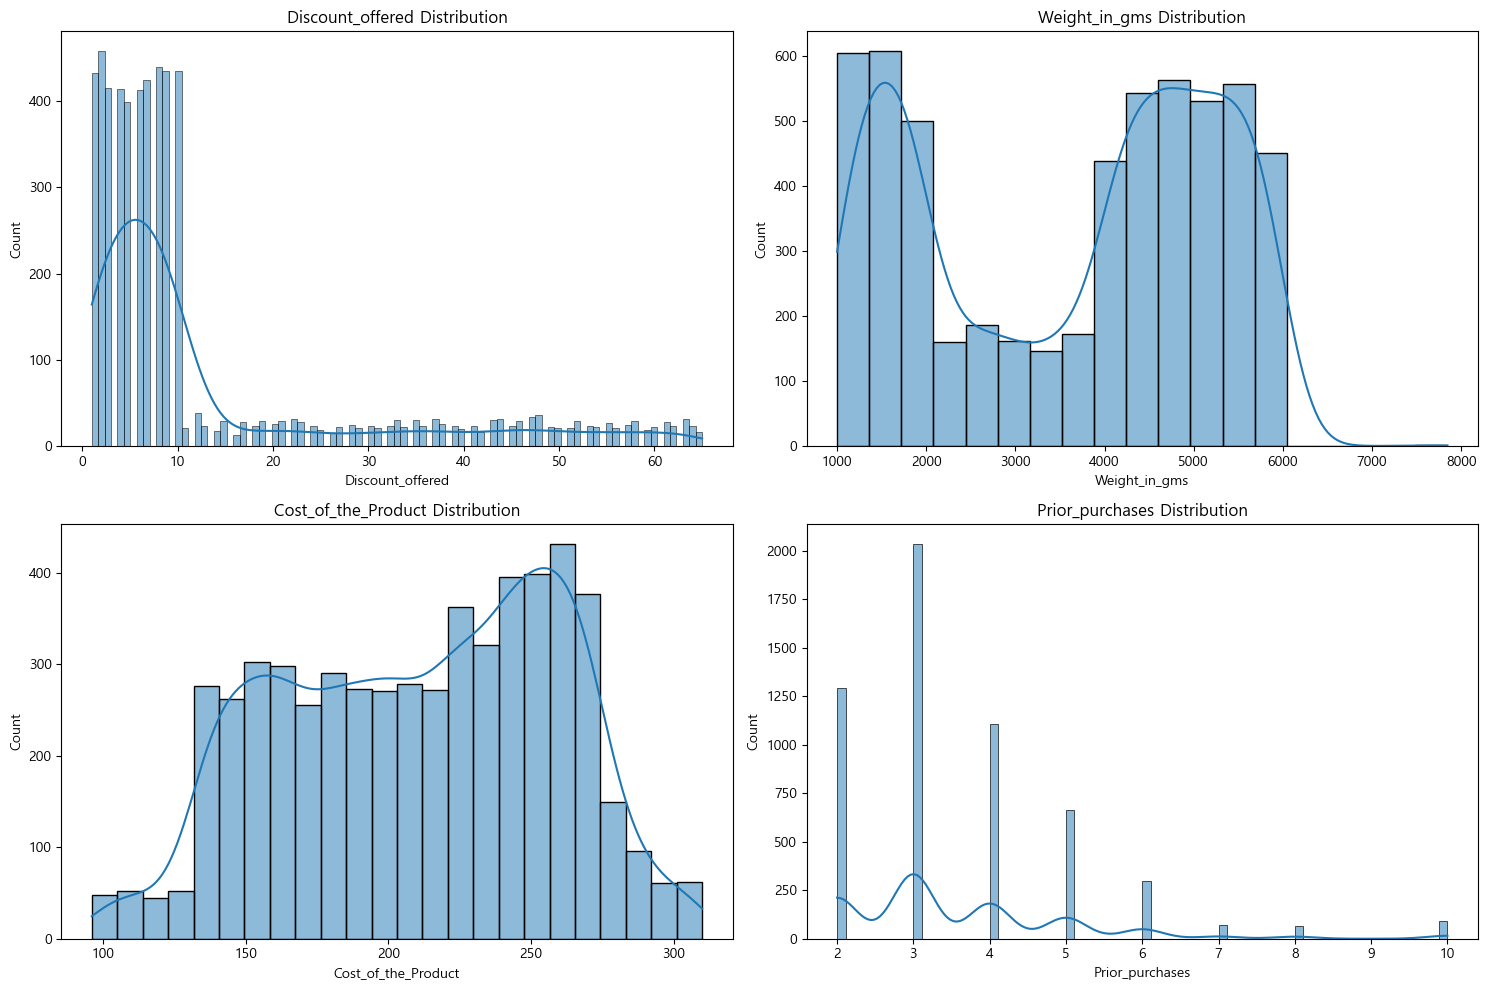

In [26]:
# 숫자형 변수 분석 : 분포 + 이상치 확인
num_features = ['Discount_offered', 'Weight_in_gms', 'Cost_of_the_Product', 'Prior_purchases']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(Train[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

> Discount_offered (할인) - ⚠️ 10.5 (지니계수가 가장 적은 게 10.5라고 계산함)
* $10.5$달러 이상의 고액 할인은 주문 폭주를 일으켜 과부하되는 듯

> Weight_in_gms (제품 무게) - 🚨 위험 구간 2~4kg
* 특정 무게 구간(2,000g~4,000g)에서 지연 데이터가 비정상적으로 많이 관찰
* 어중간한 2~4kg 무게가 포장이나 적재 시 가장 많이 지연되는 '데드 존(Dead Zone)'

*** 가설1 : 할인 품목이 2~4kg가 많지 않을까 하는 생각<br>
*** 가설2 : 가벼운것/무거운것보다 중간이 많으니까 어디 밀려났다가 한꺼번에 처리하지 않을까 하는 추측

> Cost_of_the_Product (제품 가격)
* 어느 한 곳에 쏠리지 않고 골고루 분포됨. 무게랑 같이 엮어서 **'무게 대비 가격(Value Density)'** 파생 변수를 만들기

> Prior_purchases(이전 구매 횟수)
* 3회 구매자가 가장 많고, 6회 이상부터는 데이터가 확 줄어듦
* 재구매 6회 이상 단골고객 패턴은 비슷하니, 모델이 헷갈리지 않게 하나로 묶어주기

> Weight_in_gms 가설 확인
* 가설1 : 할인 품목이 2~4kg가 많아서 지연<br>
* 가설2 : 가벼운것/무거운것보다 중간 무게가 많아서 물량이 많은만큼 지연

--- 💸 무게 구간별 할인액 통계 ---
                        mean  median  count
Weight_Group                               
1. Small (<2kg)    16.764741     8.0   1662
2. Medium (2-4kg)  32.693462    34.0    933
3. Large (>4kg)     5.569829     6.0   3036

--- 📦 무게 구간별 물동량(건수) 비교 ---
Weight_Group
3. Large (>4kg)      53.915823
1. Small (<2kg)      29.515184
2. Medium (2-4kg)    16.568993
Name: proportion, dtype: float64


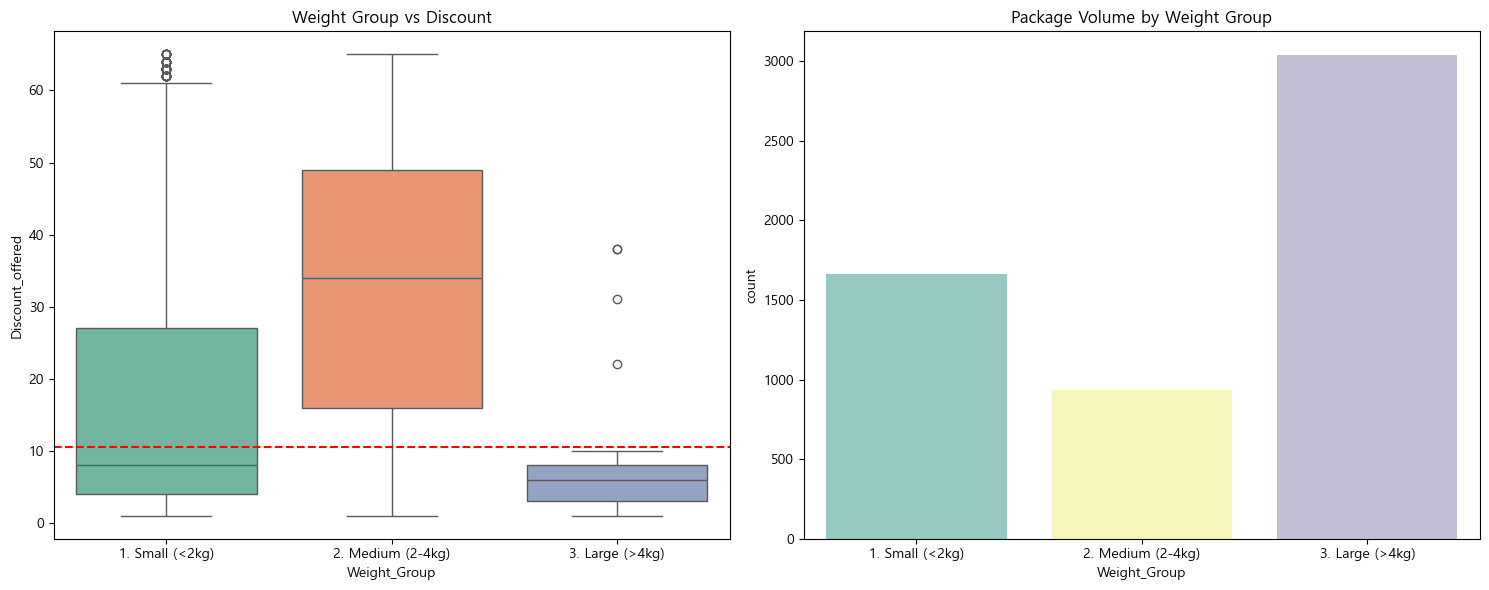

In [ ]:
# [1] 무게 구간 나누기 (2~4kg를 집중적으로 보기 위함)
def categorize_weight(w):
    if w < 2000: return '1. Small (<2kg)'
    elif 2000 <= w <= 4000: return '2. Medium (2-4kg)'
    else: return '3. Large (>4kg)'

# 전처리 중인 데이터프레임(Train)에 적용
Train['Weight_Group'] = Train['Weight_in_gms'].apply(categorize_weight)

# [2] 가설 1 확인: "2~4kg에 할인 품목이 몰려 있는가?"
# 무게 구간별 할인액(Discount_offered)의 평균과 중앙값 확인
discount_analysis = Train.groupby('Weight_Group')['Discount_offered'].agg(['mean', 'median', 'count'])
print("--- 💸 무게 구간별 할인액 통계 ---")
print(discount_analysis)

# [3] 가설 2 확인: "2~4kg 물량이 압도적으로 많아서 밀리는가?"
# 위에서 구한 'count' 컬럼이 바로 물동량(Volume)
print("\n--- 📦 무게 구간별 물동량(건수) 비교 ---")
print(Train['Weight_Group'].value_counts(normalize=True) * 100) # 퍼센트로 보기

# [4] 시각화로 한눈에 확인 (Boxplot + Countplot)
plt.figure(figsize=(15, 6))

# 왼쪽: 할인율 분포 (가설 1 검증)
plt.subplot(1, 2, 1)
sns.boxplot(data=Train, x='Weight_Group', y='Discount_offered', palette='Set2')
plt.axhline(10.5, color='red', linestyle='--', label='High Discount Line')
plt.title('Weight Group vs Discount')

# 오른쪽: 물동량 확인 (가설 2 검증)
plt.subplot(1, 2, 2)
sns.countplot(data=Train, x='Weight_Group', palette='Set3')
plt.title('Package Volume by Weight Group')

plt.tight_layout()
plt.show()

> 결과

**가설1** ⭕
* 2~4kg 그룹의 평균할인액 32.69 중앙값 34.0
* 다른 그룹(Small: 16.7달러, Large: 5.5달러)과 비교하면 압도적으로 높은 할인이 이 구간에 쏠림
* 기업이 가장 공격적으로 프로모션을 진행하는 '전략 상품군'이 바로 이 2~4kg 무게대에 집중되어 있다

**가설2** ❌
* 물동량 1위는 Large (>4kg) 그룹으로,53.9%
* Medium (2-4kg) 16.5% - 물량이 가장 적음
* 물량이 많아서 밀리는 게 아니라 '할인 폭이 너무 커서' 주문이 한꺼번에 몰리거나, 특별 관리가 필요해서 지연되는 '프로모션의 함정' 구간임

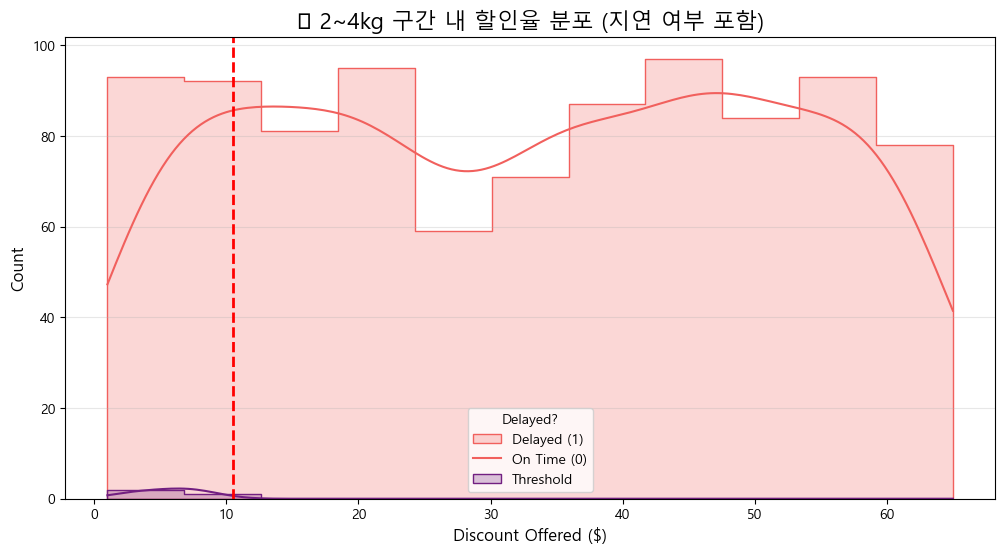

--- 📊 2~4kg 구간 심층 통계 ---
1. 전체 건수: 933건
2. 10.5$ 초과 고액 할인 건수: 781건
3. 고액 할인 비중: 🔥 83.7% 🔥


In [38]:
# [Section 2-6] 2~4kg 구간(Danger Zone) 내부의 할인율 분포 및 비중 확인

# 1. 2~4kg 데이터만 필터링
danger_weight_df = Train[(Train['Weight_in_gms'] >= 2000) & (Train['Weight_in_gms'] <= 4000)]

# 2. 시각화 (지연 여부로 색깔 구분!)
plt.figure(figsize=(12, 6))
sns.histplot(data=danger_weight_df, x='Discount_offered', hue='Reached.on.Time_Y.N', 
             kde=True, palette='magma', element="step")

# 3. 10.5 선 긋기
plt.axvline(10.5, color='red', linestyle='--', linewidth=2, label='Magic Line: 10.5$')

plt.title('📦 2~4kg 구간 내 할인율 분포 (지연 여부 포함)', fontsize=16)
plt.xlabel('Discount Offered ($)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Delayed?', labels=['Delayed (1)', 'On Time (0)', 'Threshold'])
plt.grid(axis='y', alpha=0.3)
plt.show()

# 4. 수치 확인
total_cnt = len(danger_weight_df)
high_discount_cnt = len(danger_weight_df[danger_weight_df['Discount_offered'] > 10.5])
percentage = (high_discount_cnt / total_cnt) * 100 if total_cnt > 0 else 0

print(f"--- 📊 2~4kg 구간 심층 통계 ---")
print(f"1. 전체 건수: {total_cnt}건")
print(f"2. 10.5$ 초과 고액 할인 건수: {high_discount_cnt}건")
print(f"3. 고액 할인 비중: 🔥 {percentage:.1f}% 🔥") # 소수점 첫째자리까지 표시

> 무게(Weight)와 할인(Discount)의 관계

제품 무게 2,000g~4,000g 구간은 물동량 비중은 **16.5%**로 가장 낮지만, 평균 할인액은 32.69달러로 타 구간 대비 압도적으로 높음.

결론: 해당 구간의 높은 지연율은 '물량 과부하' 때문이 아니라, 고액 할인이 집중된 프로모션 상품들의 주문 처리 과정에서 발생하는 병목 현상이 주원인으로 분석됨.

전략: 따라서 Is_Danger_Weight 파생 변수는 단순히 무게를 보는 것이 아니라, **'고할인 전략 상품군'을 식별하는 대리 변수(Proxy Variable)**로서 강력한 예측력을 가지게 됨.

### 2. Warehouse_block --> 약한 영향력의 변수 / 구역별 지연율 차이 2% 미만

--- 창고 구역별 물동량 현황 ---
Warehouse_block
F    1849
D     975
B     960
C     934
A     913
Name: count, dtype: int64


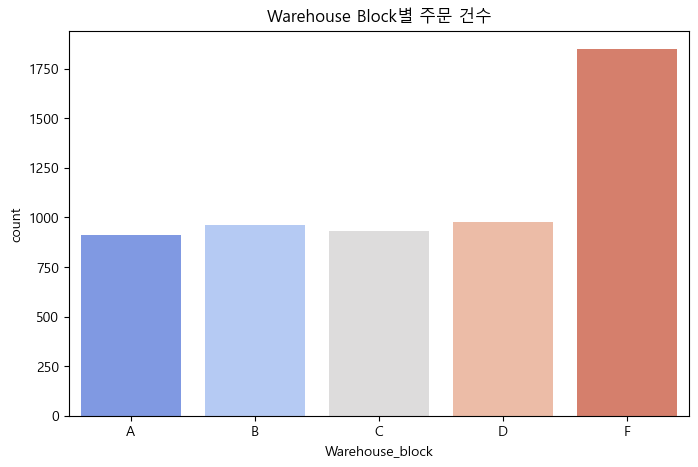

In [25]:
# 1. 구역별 주문 건수(물동량) 확인
warehouse_counts = Train['Warehouse_block'].value_counts()
print("--- 창고 구역별 물동량 현황 ---")
print(warehouse_counts)

# 2. 시각화 (막대 그래프)
plt.figure(figsize=(8, 5))
sns.countplot(data=Train, x='Warehouse_block', 
              order=['A', 'B', 'C', 'D', 'F'], # 알파벳 순서대로 정렬
              palette='coolwarm')
plt.title("Warehouse Block별 주문 건수")
plt.show()

> F 구역이 가장 큰 메인 허브거나 빈번하게 나가는 특정 품목 보관 장소일 확률

In [ ]:
# [1] 창고 구역별 지연율(평균) 계산
warehouse_delay_rate = Train.groupby('Warehouse_block')['Reached.on.Time_Y.N'].mean().reset_index()

# [2] 시각화 (Barplot)
plt.figure(figsize=(10, 6))
sns.barplot(data=warehouse_delay_rate, x='Warehouse_block', y='Reached.on.Time_Y.N', palette='coolwarm')

# 전체 평균 지연율을 점선으로 표시 (기준선)
plt.axhline(Train['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Average')

plt.title('창고 구역(Block)별 배송 지연율 비교')
plt.ylabel('지연율 (Mean of Delay)')
plt.legend()
plt.show()

# [3] 수치로 정확히 확인
print(warehouse_delay_rate.sort_values(by='Reached.on.Time_Y.N', ascending=False))

> 결론: F 물류가 거의 2배 많은데 지연율이 비슷하다면 창고 구역 자체는 지연의 원인이 아니고, 창고 안에서의 이동보다 창고 밖에서의 배송 수단이나 물건 무게 등 다른 요소가 더 큰 문제일 확률이 높다

#### 2-2. 다른 요소도 확인

In [ ]:
# 물건 무게가 유독 높은 곳이 있는가?

# [1] 창고 구역별 평균 무게 확인
warehouse_weight = Train.groupby('Warehouse_block')['Weight_in_gms'].mean().reset_index()
print("--- 창고 구역별 평균 제품 무게 ---")
print(warehouse_weight)

# [2] 시각화로 한눈에 비교 (Boxplot이 제맛!)
plt.figure(figsize=(10, 6))
sns.boxplot(data=Train, x='Warehouse_block', y='Weight_in_gms', hue='Reached.on.Time_Y.N')
plt.title('창고 구역별 무게 분포 (지연 여부 포함)')
plt.show()

In [ ]:
# 제품 중요도가 높은 게 많이 들어가는 창고?

# [2-1] 창고별 제품 중요도 비중 확인 (교차표)
importance_cross = pd.crosstab(Train['Warehouse_block'], Train['Product_importance'], normalize='index') * 100
print("--- 창고 구역별 제품 중요도 비중 (%) ---")
print(importance_cross)

# [2-2] 시각화 (누적 막대 그래프)
importance_cross.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Warehouse Block별 제품 중요도 분포')
plt.ylabel('Percentage (%)')
plt.legend(title='Importance', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# 배송 수단별 비교

# [3-1] 창고별 배송 수단 비중 확인
shipment_cross = pd.crosstab(Train['Warehouse_block'], Train['Mode_of_Shipment'], normalize='index') * 100
print("--- 창고 구역별 배송 수단 비중 (%) ---")
print(shipment_cross)

# [3-2] 시각화 (누적 막대 그래프)
shipment_cross.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Paired')
plt.title('Warehouse Block별 배송 수단 분포')
plt.ylabel('Percentage (%)')
plt.legend(title='Shipment Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

> 다른 변수 추가해도 큰 영향력 없음

In [ ]:
print(Train.columns)

### 3. Mode_of_Shipment --> 약한 영향력의 변수
* 일반적 시각
* Ship (배): 가장 저렴하고 많이 실을 수 있지만, 기상 악화나 항만 적체에 매우 취약 (지연 가능성 높음)
* Flight (비행기): 가장 빠르지만 통관 절차가 복잡하고 비용이 비쌈 (속도는 빠르나 행정적 지연 가능성)
* Road (도로): 근거리 배송에 유리하지만 교통 체증이라는 변수

In [ ]:
# [1] 낱개 분석: 회사는 주로 뭘 이용하나?
shipment_counts = Train['Mode_of_Shipment'].value_counts()
print("--- 배송 수단별 주문 건수 ---")
print(shipment_counts)

# [2] 지연율 분석: 누가 제일 느린가?
shipment_delay = Train.groupby('Mode_of_Shipment')['Reached.on.Time_Y.N'].mean().sort_values(ascending=False)
print("\n--- 배송 수단별 지연율 (평균) ---")
print(shipment_delay)

# [3] 시각화 (한 번에 보기)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 왼쪽: 수단별 물량 분포
sns.countplot(data=Train, x='Mode_of_Shipment', ax=axes[0], palette='Set2')
axes[0].set_title('Mode of Shipment Distribution')

# 오른쪽: 수단별 지연율 (전체 평균선 포함)
sns.barplot(x=shipment_delay.index, y=shipment_delay.values, ax=axes[1], palette='coolwarm')
axes[1].axhline(Train['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Avg')
axes[1].set_title('Delay Rate by Shipment Mode')
axes[1].set_ylim(0, 1)

plt.show()

> 해상 운송 기반의 물류 회사. 수단별 차이 근소->물건자체의 속성이 중요한가?

#### 3-2. + 무게

In [ ]:
# 무게
# # [1] 수단별, 지연 여부별 '평균 무게' 확인
weight_stats = Train.groupby(['Mode_of_Shipment', 'Reached.on.Time_Y.N'])['Weight_in_gms'].mean().unstack()
print("--- 배송 수단 및 지연 여부별 평균 무게 ---")
print(weight_stats)

# [2] 시각화: 수단별 무게 분포와 지연의 상관관계
plt.figure(figsize=(12, 7))
sns.boxplot(data=Train, x='Mode_of_Shipment', y='Weight_in_gms', hue='Reached.on.Time_Y.N', palette='Set1')

plt.title('배송 수단별 무게 분포와 지연 여부의 관계')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

> 지연율: 비행기(60.4%), 배(59.7%), 자동차(58.7%) / 수단별로 차이 1%p 내외
>  + 무게가 더 큰 요소일 확률 높음 -> 무게 컬럼 분석 때 다시 확인

### 4~5. Customer_care_calls, Customer_rating --> drop이 유리

In [ ]:
# 1. 배송 지연 여부에 따른 평점 차이
print(Train.groupby('Reached.on.Time_Y.N')['Customer_rating'].mean())

# 2. 고객 센터 전화 횟수와 평점의 관계 (불만이 점수로 이어지는지 확인)
# 전화를 많이 할수록 평점이 낮아진다면 '서비스 점수'일 확률
print(Train.groupby('Customer_care_calls')['Customer_rating'].mean())

In [ ]:
# 한 화면에 2개의 그래프
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# [1] 지연 여부에 따른 평점 평균 (Barplot)
sns.barplot(ax=axes[0], data=Train, x='Reached.on.Time_Y.N', y='Customer_rating')
axes[0].set_title('1. 지연 여부별 평균 평점')
axes[0].set_ylim(0, 5) # 평점은 1~5점 사이니까 범위를 고정!

# [2] 전화 횟수에 따른 평점 평균 (Lineplot)
# 변화의 흐름을 보기 위해 선 그래프를 씁니다.
sns.lineplot(ax=axes[1], data=Train, x='Customer_care_calls', y='Customer_rating', marker='o')
axes[1].set_title('2. 전화 횟수별 평균 평점 추이')
axes[1].set_ylim(0, 5)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# hue='Reached.on.Time_Y.N'을 추가해서 지연 여부별로 선을 나눕니다.
sns.lineplot(data=Train, x='Customer_care_calls', y='Customer_rating', 
             hue='Reached.on.Time_Y.N', marker='o')

plt.title('전화 횟수별 평균 평점 (지연 여부별 비교)')
plt.ylabel('평균 평점')
plt.xlabel('고객 센터 전화 횟수')
plt.ylim(0, 5)
plt.legend(title='지연 여부 (1=지연)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

가설1 : "배송이 늦더라도 **할인(Discount_offered)**이 높거나 제품이 마음에 들면 고객은 평점을 깎지 않는다. 즉, 고객은 속도보다 가격에 더 관대하다."

가설2 : "이 쇼핑몰 고객들은 평점을 줄 때 중간 점수(3점)를 주는 경향이 강하다." > 데이터로 확인할 수 없음

...????

> 가설 1 확인

In [ ]:
# [0-1] 먼저 Train 데이터에 Is_High_Discount 컬럼을 다시 만듭니다.
# 10.5달러 초과면 1, 아니면 0
Train['Is_High_Discount'] = (Train['Discount_offered'] > 10.5).astype(int)

# [0-2] 그 다음에 '지연된 데이터'만 따로 추출해야 Is_High_Discount가 포함됩니다.
delayed_shipments = Train[Train['Reached.on.Time_Y.N'] == 1].copy()

# 1. 지연된 데이터(Reached.on.Time_Y.N == 1)만 따로 추출
delayed_shipments = Train[Train['Reached.on.Time_Y.N'] == 1].copy()

# 2. 지연된 건들 중에서 '고할인' vs '저할인' 그룹의 평점 비교
plt.figure(figsize=(10, 6))
sns.barplot(data=delayed_shipments, x='Is_High_Discount', y='Customer_rating')

plt.title("배송 지연 시: 할인 폭에 따른 고객 평점 비교")
plt.xlabel("할인 폭 (0: 10.5$ 이하, 1: 10.5$ 초과)")
plt.ylabel("평균 평점")
plt.ylim(0, 5)
plt.show()

# 3. 수치로도 확인
print(delayed_shipments.groupby('Is_High_Discount')['Customer_rating'].mean())

> 큰 차이 X --> 통계적으로 변별력이 0에 수렴할 것으로 추정
* [Customer_rating], [Customer_care_calls] 컬럼은 drop 하는 것이 모델 학습에 유리함

### 6. Cost_of_the_Product --> 약한 영향력의 변수
* 가설: 비싼 물건은 빠르게 도착하지 않을까??

In [ ]:
# [1] 낱개 분석: 가격이 어떻게 분포되어 있나?
plt.figure(figsize=(10, 5))
sns.histplot(Train['Cost_of_the_Product'], kde=True, color='skyblue')
plt.title('제품 가격 분포 (Cost Distribution)')
plt.show()

# [2] 지연 여부에 따른 가격 차이 분석
plt.figure(figsize=(10, 6))
sns.boxplot(data=Train, x='Reached.on.Time_Y.N', y='Cost_of_the_Product', palette='Set2')
plt.title('지연 여부별 제품 가격 비교')
plt.show()

# [3] 수치로 확인
print("지연 여부별 평균 가격:")
print(Train.groupby('Reached.on.Time_Y.N')['Cost_of_the_Product'].mean())

> 가설 틀렸음 -> 비싸다고 제시간에 오지는 않음. (* 지연/정시 도착 가격이 비슷하게 형성되어 있음)

### 7. Prior_purchases --> ⭐ 유의미한 영향력의 변수
* 구매 횟수는 지연율을 최대 14%p(64%(3) -> 50%(5)) 변화 시킴

* 2~3회 (신규)	약 63~64%	지연율이 가장 높음 (관리 우선순위 낮음)
* 4회 (충성 진입)	약 53%	지연율이 급격히 감소 시작
* 5회 (Sweet Spot)	약 50%	이 데이터셋의 VIP 구간 (지연율 최저)
* 6회 이상 (단골)	약 57%	다시 소폭 상승하나 신규보다는 낮음

In [ ]:
# [1] 과거 구매 횟수(Prior_purchases)별 지연율 계산
# mean()을 쓰는 이유는 1(지연)의 비중을 알기 위해서
prior_delay_rate = Train.groupby('Prior_purchases')['Reached.on.Time_Y.N'].mean().reset_index()

# [2] 결과 출력
print("--- 과거 구매 횟수(Prior_purchases)별 지연율 ---")
print(prior_delay_rate)

# [3] 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=prior_delay_rate, x='Prior_purchases', y='Reached.on.Time_Y.N', palette='magma')
plt.axhline(Train['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Avg')
plt.title('Prior Purchases vs Delay Rate')
plt.show()

* 2~3회 : 지연율이 62~64% (관심 밖?)
* 4~6회 : 지연율이 50~54% (가장 관리가 잘 됨!)
* 7회 이상 : 다시 지연율이 66~67% (왜?? 데이터 표본이 적은가?) >> 확인

In [ ]:
# Prior_purchases별로 지연율(mean)과 데이터 개수(count)를 동시에 계산
prior_analysis = Train.groupby('Prior_purchases')['Reached.on.Time_Y.N'].agg(['mean', 'count']).reset_index()

# 컬럼 이름을 보기 좋게 바꿔줄게요
prior_analysis.columns = ['Prior_purchases', 'Delay_Rate', 'Sample_Size']

# 결과 확인
print("--- 과거 구매 횟수별 지연율 및 표본 크기 ---")
print(prior_analysis)

* 2~5회는 샘플수가 1000~3000개 사이 6~10은 샘플수가 현저히 떨어짐
* 7회 이상의 지연율은 단골을 홀대하는게 아니라 표본이 적어서 생기는 문제일수도
* XGBoost 모델은 이를 과적합하여 판단할 수 있으므로 6~10회 체급을 비슷하게 묶어서 만들어줌

In [ ]:
# 'Prior_purchases'가 6 이상인 것들은 모두 6으로 통일 (별도 그룹화)
# 6, 7, 8, 10을 모두 '6'이라는 대표값으로 뭉치기
Train['Prior_purchases_cleaned'] = Train['Prior_purchases'].apply(lambda x: x if x < 6 else 6)

# 다시 한번 지연율과 개수를 확인
cleaned_analysis = Train.groupby('Prior_purchases_cleaned')['Reached.on.Time_Y.N'].agg(['mean', 'count'])
print(cleaned_analysis)

In [ ]:
# [1] 시각화 준비
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# [2] 왼쪽: 데이터의 체급 (Sample Size)
# 뭉쳐진 데이터(6회 이상) 확인
sns.countplot(data=Train, x='Prior_purchases_cleaned', ax=axes[0], palette='Blues')
axes[0].set_title('데이터의 체급 (Sample Size by Group)')
axes[0].set_xlabel('Prior Purchases (6 = 6 or more)')
axes[0].set_ylabel('Count')

# [3] 오른쪽: 데이터의 성적 (Delay Rate)
# 5회 구간에서 지연율 떨어지는 구간 찾기
sns.barplot(data=Train, x='Prior_purchases_cleaned', y='Reached.on.Time_Y.N', ax=axes[1], palette='Oranges')
axes[1].axhline(Train['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Avg')
axes[1].set_title('데이터의 성적 (Delay Rate by Group)')
axes[1].set_xlabel('Prior Purchases (6 = 6 or more)')
axes[1].set_ylabel('Delay Rate (Mean)')
axes[1].set_ylim(0, 1) # 지연율 0~1 사이

plt.tight_layout()
plt.show()

* 2~3회 (신규)	약 63~64%	지연율이 가장 높음 (관리 우선순위 낮음) : * 추측: 할인을 많이해서 신규로 진입한 고객일수도?
* 4회 (충성 진입)	약 53%	지연율이 급격히 감소 시작
* 5회 (Sweet Spot)	약 50%	이 데이터셋의 VIP 구간 (지연율 최저)
* 6회 이상 (단골)	약 57%	다시 소폭 상승하나 신규보다는 낮음

> 가설검증 단계

In [ ]:
# 구매 횟수(Prior_purchases)별 평균 할인액(Discount_offered) 계산
analysis = Train_ready.groupby('Prior_purchases')['Discount_offered'].mean()
print("--- 구매 횟수별 평균 할인액 ---")
print(analysis)

In [ ]:
# [1 & 2] 구매 횟수별 평균 가격과 무게 확인
# 이 코드를 돌리면 우리 단골 고객들이 어떤 특징을 가졌는지 바로 보입니다.

loyalist_analysis = Train_ready.groupby('Prior_purchases').agg({
    'Cost_of_the_Product': 'mean',  # 1. 평균 가격
    'Weight_in_gms': 'mean',        # 2. 평균 무게
    'Discount_offered': 'mean',     # (참고용) 평균 할인액
    'Reached.on.Time_Y.N': 'mean'   # (참고용) 실제 지연율
}).reset_index()

print("--- [결과] 구매 횟수별 가격/무게 통계 ---")
print(loyalist_analysis)

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# 무게와 지연율의 관계 시각화
sns.barplot(data=loyalist_analysis, x='Prior_purchases', y='Weight_in_gms', alpha=0.5, ax=ax1, color='blue')
ax2 = ax1.twinx()
sns.lineplot(data=loyalist_analysis, x=range(len(loyalist_analysis)), y='Reached.on.Time_Y.N', marker='o', color='red', ax=ax2)

plt.title("구매 횟수별 무게(막대)와 지연율(선)의 관계")
plt.show()

> 원인 추정: 단골 고객 유지를 위해 고액할인(평균13~16)을 제공함.

* "10달러 초과 할인시 지연" 로직이 단골 고객에게도 똑같이 적용됨 (할인이 많응면 주문이 몰리거나 저가 배송 수단을 선택할 가능성)

> 해결 전략
* 단골 고객은 별도의 단골 전용라인 택배로 지연율 강제 관리
* 단순 가격 할인보다 무료 특급 택배 서비스 제공 ? >> 근데 이건 배달 빨리 받았다고 만족률이 높다면 좋은 정책이지만 만족도 높지 않음.

> 추가 가설 (6번 이상 구매한 사람들 만족도 다를까?) >> 차이 없음

In [ ]:
# [1] 데이터 분리: 6회 이상(Loyal) vs 5회 이하(General)
loyal_df = Train_ready[Train_ready['Prior_purchases'] >= 6].copy()
general_df = Train_ready[Train_ready['Prior_purchases'] < 6].copy()

# [2] 지연 여부별 평균 평점 비교 데이터 생성
def get_rating_analysis(df, label):
    res = df.groupby('Reached.on.Time_Y.N')['Customer_rating'].mean().reset_index()
    res['Group'] = label
    return res

loyal_res = get_rating_analysis(loyal_df, 'Loyal (6+)')
general_res = get_rating_analysis(general_df, 'General (2-5)')

combined_res = pd.concat([loyal_res, general_res])

# [3] 시각화: 지연 여부에 따른 평점 변화 (단골 vs 일반)
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_res, x='Group', y='Customer_rating', hue='Reached.on.Time_Y.N')
plt.title("지연 여부에 따른 평점 변화: 단골 vs 일반")
plt.ylabel("평균 평점 (1~5)")
plt.ylim(0, 5)
plt.legend(title='Delayed (1: Yes)')
plt.show()

print("--- [결과] 그룹별 지연 시 평점 하락폭 ---")
print(combined_res)

⭐ 과적합(Overfitting) 방지 : 기존 Prior_purchases 대신, **Prior_purchases_cleaned**를 메인 변수로 사용

In [ ]:
Train['Prior_purchases_cleaned'].unique()

In [ ]:
# [1] 여기서 df는 가짜 이름
def get_cleaned_data(df):
    temp_df = df.copy() # 원본 보호를 위해 복사본 생성
    temp_df['Prior_purchases_cleaned'] = temp_df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)
    temp_df = temp_df.drop('Prior_purchases', axis=1)
    return temp_df

# [2] 현실 (Train이 진짜)
# 원본 Train은 그대로 두고, 결과물만 Train_ready에 담기
Train_ready = get_cleaned_data(Train)

# [3] 구분 확인
print(f"원본 컬럼 개수: {len(Train.columns)}")       # Prior_purchases가 살아있음
print(f"전처리 컬럼 개수: {len(Train_ready.columns)}") # 새 변수만 있고 원본은 삭제됨

In [ ]:
print("--- 원본(Train) 컬럼 목록 ---")
print(Train.columns.tolist())

print("\n--- 전처리(Train_ready) 컬럼 목록 ---")
print(Train_ready.columns.tolist())

* Train : 원본
* Train_ready : 컬럼 바꾼 것

### 8. Product_importance  --> 유의미한 영향력의 변수 (조건부)
> 최악의 조합: High + Ship (0.66), High + Road(0.65)

> 의외로 괜찮음 : Medium + Road(0.56)
* 조건부 로직으로 확률을 높여볼까? (importance == high + mode == Ship인 데이터는 지연확률높음)

In [ ]:
# [1] 제품 중요도별 지연율과 샘플 수 확인
importance_report = Train.groupby('Product_importance')['Reached.on.Time_Y.N'].agg(['mean', 'count']).reset_index()

# [2] 보기 좋게 정렬 (low -> medium -> high 순서로)
importance_report['Product_importance'] = pd.Categorical(importance_report['Product_importance'], categories=['low', 'medium', 'high'], ordered=True)
importance_report = importance_report.sort_values('Product_importance')

print("--- 제품 중요도별 지연율 성적표 ---")
print(importance_report)

# [3] 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_report, x='Product_importance', y='mean', palette='coolwarm')
plt.axhline(Train['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Avg')
plt.title('Product Importance vs Delay Rate')
plt.show()

> Low: 지연율 59.7% / Medium: 지연율 58.5% / High: 지연율 64.8%
* 샘플 수(count): high (768개), low(4,214개), medium(3,817개) / 노이즈가 섞여있을 확률 큼

* 추측의 영역 : 배송난이도? 중요도가 high인 제품들은 아마 비싸거나, 깨지기 쉽거나, 크기가 큰 제품일 가능성. 검수 과정이 더 까다롭거나 배송 기사님이 더 조심조심 다루다 보니 오히려 시간이 더 걸리지 않을까?

> 결론: 중요도가 높다고 빨리가지는 않음. 

In [ ]:
# 라벨 인코딩 Label Encoding
def get_cleaned_data(df):
    temp_df = df.copy()
    
    # [1] 이전 구매 횟수 처리 (이미 처리함)
    temp_df['Prior_purchases_cleaned'] = temp_df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)
    temp_df = temp_df.drop('Prior_purchases', axis=1)
    
    # [2] 제품 중요도 처리 (새로 추가!)
    # 글자를 숫자로 매핑
    mapping = {'low': 1, 'medium': 2, 'high': 3}
    temp_df['Product_importance'] = temp_df['Product_importance'].map(mapping)
    
    return temp_df

Train_ready = get_cleaned_data(Train)

In [ ]:
# [체크 1] 인코딩 후 결측치 확인
print("인코딩 후 결측치 개수:", Train_ready['Product_importance'].isnull().sum())

# [체크 2] 상관계수 확인
correlation = Train_ready[['Product_importance', 'Reached.on.Time_Y.N']].corr()
print("--- 중요도와 지연율의 상관계수 ---")
print(correlation)

# [체크 3] 개수 비중 확인
print(Train_ready['Product_importance'].value_counts())

In [ ]:
Train_ready.head()

#### 8-2. +다른변수 교차분석

In [ ]:
# [1] 중요도(Product_importance) x 운송수단(Mode_of_Shipment) 교차 분석
importance_ship_analysis = Train.groupby(['Product_importance', 'Mode_of_Shipment'])['Reached.on.Time_Y.N'].mean().unstack()

print("--- 중요도와 운송수단별 지연율 ---")
print(importance_ship_analysis)

# [2] 시각화: 히트맵으로 어디가 '지연'이 많이 되는지 확인
plt.figure(figsize=(10, 6))
sns.heatmap(importance_ship_analysis, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Heatmap: Importance & Shipment vs Delay Rate')
plt.show()

> 최악의 조합: High + Ship (0.66), High + Road(0.65)
> 의외로 괜찮음 : Medium + Road(0.56)

* 조건부 로직 importance == high 이면서 mode == Ship인 데이터는 일단 지연될 확률이 높아질듯

### 9. Gender --> drop

### 10. Discount_offer --> ⭐⭐⭐ 가장 높은 상관관계
>현상: 할인이 높으면 주문량이 폭주 / 10달러 초과한 할인은 100% 지연(1) 
>> 100% 지연구간을 이진수(0,1)로 표현하여 새로 컬럼 만듦 > 학습속도와 정확도를 올려줌 (모델이 10 이상인지 아닌지 확인하는 것보다 1,0으로 확인하는 게 더 빠름. 1이면 무조건 지연으로 처리할 수 있음)

In [ ]:
# 전체적인 분포 확인

# [1] 할인 폭에 따른 지연(1)과 정시(0)의 분포 시각화
plt.figure(figsize=(12, 6))
sns.kdeplot(data=Train, x='Discount_offered', hue='Reached.on.Time_Y.N', fill=True)
plt.title('Discount Offered vs Delay Rate (The Cliff)')
plt.axvline(x=10, color='red', linestyle='--', label='Magic Line: 10')
plt.legend()
plt.show()

# [2] 숫자로 증명하기 (10달러 이하 vs 초과)
Train['over_10'] = Train['Discount_offered'] > 10
print("--- 10달러 할인 기준 지연율 비교 ---")
print(Train.groupby('over_10')['Reached.on.Time_Y.N'].mean())

* 할인 폭 1~10달러: 지연/정시 데이터가 섞여 있음 (운에 맡겨야 함)
* 할인 폭 10달러 초과: 정시(0)의 그래프가 0이 되는 지점이 보임
* 결론: 할인이 11달러 이상 -> 배송 무조건 지연 (100%)

In [ ]:
# 지연된 데이터만 모아보기
# 배송 지연 여부에 따른 할인 차이 확인

print("배송 지연 여부별 평균 할인:")
print(Train.groupby('Reached.on.Time_Y.N')['Discount_offered'].mean())

# 시각화
sns.boxplot(x='Reached.on.Time_Y.N', y='Discount_offered', data=Train)
plt.show()

>현상: 할인이 높으면 주문량 폭주

In [ ]:
# 할인 10$를 기준으로 지연율 차이 계산
over_10 = Train[Train['Discount_offered'] > 10]['Reached.on.Time_Y.N'].mean()
under_10 = Train[Train['Discount_offered'] <= 10]['Reached.on.Time_Y.N'].mean()

print(f"할인 10$ 초과 시 지연율: {over_10:.2%}")
print(f"할인 10$ 이하 시 지연율: {under_10:.2%}")

In [ ]:
def get_cleaned_data(df):
    temp_df = df.copy() # [A] 원본 보호:
    
    # 1. 이전 구매 횟수 처리
    # [B] 6 이상 뭉치기: 데이터의 희소성(Sparsity) 문제를 로직으로 해결함.
    # temp_df['Prior_purchases_cleaned'] = temp_df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)
    # temp_df = temp_df.drop('Prior_purchases', axis=1) # 원본 삭제
    
    # # 2. 제품 중요도 라벨 인코딩
    # # [C] Ordinal Encoding: low < medium < high의 '급'을 모델에게 숫자로 주입
    # mapping = {'low': 1, 'medium': 2, 'high': 3}
    # temp_df['Product_importance'] = temp_df['Product_importance'].map(mapping)
    
    # 3. 할인 폭 처리
    # [D] Is_Danger_Discount
    # 100% 지연구간을 이진수(0,1)로 표현
    temp_df['Is_Danger_Discount'] = (temp_df['Discount_offered'] > 10).astype(int)
    
    return temp_df

Train_ready = get_cleaned_data(Train)
Train_ready

### 11. Weight_in_gms --> ⭐⭐ 높은 상관관계

* 정시 구역 (Safe Zone): 아주 가볍거나(1000~2000g), 아주 무거운(4000~6000g) 물건들은 지연율이 상대적으로 낮음
* 지연 구역 (Danger Zone): 2000g에서 4000g 사이 물건들은 지연율이 **90~100%**
> 2~4kg 물건이 늦게 오는 이유는 그 무게의 할인이 높기 때문인 경우가 많았음. 무게보다는 할인이 더 큰 영향력
* ! 2~4kg는 샘플수가 충분하지만 6kg 이상 데이터는 count가 1개씩 데이터가 부족 

In [ ]:
# 무게 분포 확인
# [1] 무게에 따른 지연(1)과 정시(0)의 분포 확인 (KDE Plot)
plt.figure(figsize=(12, 6))
sns.kdeplot(data=Train, x='Weight_in_gms', hue='Reached.on.Time_Y.N', fill=True)
plt.title('Weight in gms vs Delivery Status (KDE Plot)')
plt.show()

# [2] 숫자로 더 자세히 보기 위해 무게를 500g 단위로 쪼개서 확인
Train['Weight_Bin'] = pd.cut(Train['Weight_in_gms'], bins=range(1000, 8000, 500))
weight_analysis = Train.groupby('Weight_Bin')['Reached.on.Time_Y.N'].mean()

print("--- 무게 구간별 지연율 성적표 ---")
print(weight_analysis)

* 정시 구역 (Safe Zone): 아주 가볍거나(1000~2000g), 아주 무거운(4000~6000g) 물건들은 지연율이 상대적으로 낮음
* 지연 구역 (Danger Zone): 2000g에서 4000g 사이 물건들은 지연율이 **90~100%**

가벼운 물건: 퀵서비스나 소형 전용 라인으로 빠르게 처리될 수 있음

무거운 물건: 대형 화물 전용 차량으로 계획적으로 배송

애매한 무게 (2~4kg): 소형으로 분류하기엔 무겁고, 대형으로 분류하기엔 작아서 물류 센터 한구석에 쌓여 있다가 처리가 밀릴 가능성이 크다. 
혹은 특정 프로모션(할인 많이 해주는 제품군)이 이 무게에 집중되어 있을 수도 있음 >> 이건 확인 가능할 듯?

In [ ]:
# 특정 프로모션이 2~4kg에 집중되어 있나?

# [1] 무게 구간별 평균 할인폭 확인
discount_by_weight = Train.groupby('Weight_Bin')['Discount_offered'].agg(['mean', 'max', 'count'])

print("--- 무게 구간별 할인폭 실태조사 ---")
print(discount_by_weight)

# [2] 시각화: 2~4kg 구간에 10달러 이상의 할인이 얼마나 몰려있는지 확인
plt.figure(figsize=(10, 6))
sns.boxplot(data=Train, x='Weight_Bin', y='Discount_offered')
plt.axhline(10, color='red', linestyle='--', label='Magic 10$')
plt.xticks(rotation=45)
plt.title('Is High Discount concentrated in 2-4kg?')
plt.show()

* 2~4kg 물건이 늦게 오는 이유는 그 무게의 할인율이 높기 때문인 경우가 많았음. 무게보다는 할인율이 더 큰 영향력이 있다는 걸 알 수 있음
* ! 2~4kg는 샘플수가 충분하지만 6kg 이상 데이터는 count가 1개씩 데이터가 부족함. 
* 4kg 기점으로 할인이 칼같이 잘림. 4kg 넘으면 무거운 물건 할인 해주지 않을 수도 (추측-데이터에는 영향X)

#### 9-2. +다른요소 교차분석

In [ ]:
# 무게 x 할인폭

# 무게와 할인폭의 상관관계 시각화 (산점도)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Train, x='Weight_in_gms', y='Discount_offered', hue='Reached.on.Time_Y.N', alpha=0.5)
plt.axhline(10, color='red', linestyle='--')
plt.title('Weight vs Discount (Color by Delay)')
plt.show()

* 무게는 운송 수단에 따라 무게감이 다르다 (비행기 4kg는 무거운 축에 속하지만 배 4kg는 가벼운 축에 속함)
> 무게 x 운송수단 지연율 확인 필요

In [ ]:
# 무게 X 운송수단별

# [1] 무게 구간(Weight_Bin)과 운송수단별 지연율 교차 분석
weight_ship_pivot = Train.groupby(['Weight_Bin', 'Mode_of_Shipment'])['Reached.on.Time_Y.N'].mean().unstack()

print("--- 무게 구간 x 운송수단별 지연율 ---")
print(weight_ship_pivot)

# [2] 시각화: 히트맵
plt.figure(figsize=(12, 6))
sns.heatmap(weight_ship_pivot, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Heatmap: Weight & Shipment Mode vs Delay Rate')
plt.show()

In [ ]:
# 2~4kg 사이인지 아닌지를 1,0으로 바꿈.
def get_cleaned_data(df):
    temp_df = df.copy()
    
    # # [1] 이전 구매 횟수 (6회 이상 뭉치기)
    # temp_df['Prior_purchases_cleaned'] = temp_df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)
    
    # # [2] 제품 중요도 (라벨 인코딩: low=1, medium=2, high=3)
    # mapping = {'low': 1, 'medium': 2, 'high': 3}
    # temp_df['Product_importance'] = temp_df['Product_importance'].map(mapping)
    
    # # [3] 할인 폭 (10달러 초과 여부 - 추가 컬럼 생성1)
    # temp_df['Is_High_Discount'] = (temp_df['Discount_offered'] > 10).astype(int)
    
    # [4] 무게 (2000~4000g 구간 여부 - 추카 컬럼 생성2)
    # 2~4kg 이내는 1, 나머지는 (6이상도) 0
    temp_df['Is_Danger_Weight'] = temp_df['Weight_in_gms'].between(2000, 4000).astype(int)
    
    # #[5] 불필요해진 원본 컬럼들 드랍 (깔끔하게 하려면 (선택사항))
    # temp_df = temp_df.drop(['Prior_purchases'], axis=1)
    
    return temp_df

Train_ready = get_cleaned_data(Train)
Train_ready.head()

### 결론
> 현재 데이터상 고할인-고지연의 상관관계는 뚜렷하나, 그 인과관계를 확정 짓기에는 추가 변수가 부족함. 

* 'ID' ----------------------- X
* 'Warehouse_block' ---------- F물량 가장 많지만 지연율 비슷. 창고위치는 영향 X
* 'Mode_of_Shipment' --------- 할인 규모 앞에서는 평등하게 늦음 / 운송 수단 개선 해결책 X
* 'Customer_care_calls' ------ 전화횟수 많다고 배송 더 빨리오거나 늦어지는 뚜렷한 인과관계 부족 --> 가격 비싼데 지연이라면 자주 전화했을까?
* 'Customer_rating' ---------- 지연 발생해도 평점은 3.46~3.47점대
* 'Cost_of_the_Product'------- 제품이 비쌀수록 무게가 가벼워지는 경향(4~5회 구매구간)이 있어 지연율 하락에 간접적인 영향 --> 비쌀수록 무게가 가벼워지나? 무게당 가격 (value)이 더 중요할수도? 그리고 log 취해서 그래프 다시 그려보는 것도 방법?
* 'Prior_purchases' ---------- 6회이상 단골에게 고할인 주는 마케팅 정책 때문에 지연율이 다시 높아짐 U자형 패턴 -> u자형 패턴인건 맞는데 단골 고할인 마케팅 정책여부는 모르잖아? 데이터에 안 나옴.
* 'Product_importance' ------- 고가/저가 제품군 분류 보조 지표 (사람이 매긴 등급)--> 무게당 가격으로 치환해볼까? / > Low: 지연율 59.7% / Medium: 지연율 58.5% / High: 지연율 64.8% / * 샘플 수(count): high (768개), low(4,214개), medium(3,817개) / 노이즈가 섞여있을 확률 큼 / * 추측의 영역 : 배송난이도? 중요도가 high인 제품들은 아마 비싸거나, 깨지기 쉽거나, 크기가 큰 제품일 가능성. 검수 과정이 더 까다롭거나 배송 기사님이 더 조심조심 다루다 보니 오히려 시간이 더 걸리지 않을까? --- 결론: 중요도가 높다고 빨리가지는 않음. 
* 'Gender' ------------------- X
* 'Discount_offered' --------- ⭐ 주범. 10.5달러 임계점 넘으면 배송 수단 , 창고 불문 지연율 100%
* 'Weight_in_gms' ------------ ⭐ 2~4kg 구간에서 지연 집중되는 위험 무게 패턴 + 할인과 결합시 가장 영향력이 큼

* 'Reached.on.Time_Y.N' ----------> 정답

In [ ]:
# [1] 새로운 수사 단서(파생 변수) 생성
def create_investigative_features(df):
    temp = df.copy()
    
    # 1. 가치 밀도: 작고 비싼 녀석인가, 크고 싼 녀석인가?
    temp['Value_Density'] = temp['Cost_of_the_Product'] / temp['Weight_in_gms']
    
    # 2. 로그 가격: 가격의 편차를 줄여서 모델의 시야를 확보
    temp['Log_Cost'] = np.log1p(temp['Cost_of_the_Product'])
    
    # 3. 분노의 전화 지수: 비싼 물건인데 전화까지 많이 했다면?
    temp['Care_per_Cost'] = temp['Customer_care_calls'] / temp['Cost_of_the_Product']
    
    return temp

# 데이터 적용 (Train_ready가 현재 사용 중인 데이터프레임 이름이라고 가정)
Train_final = create_investigative_features(Train_ready)

# [2] 핵심 변수들과 지연율의 상관관계 확인
cols_to_check = ['Reached.on.Time_Y.N', 'Value_Density', 'Log_Cost', 'Care_per_Cost', 'Discount_offered', 'Weight_in_gms']
correlation_matrix = Train_final[cols_to_check].corr()

print("--- [결과] 새로운 변수들의 지연율 상관계수 ---")
print(correlation_matrix['Reached.on.Time_Y.N'].sort_values(ascending=False))

# [3] 시각화: '무게당 가격'이 높을수록(비싸고 작을수록) 지연이 적은가?
plt.figure(figsize=(10, 6))
# 가치 밀도를 5개 구간으로 나누어 지연율 확인
Train_final['Value_Bin'] = pd.qcut(Train_final['Value_Density'], q=5)
sns.barplot(data=Train_final, x='Value_Bin', y='Reached.on.Time_Y.N', palette='viridis')
plt.title("가치 밀도(Value Density) 구간별 지연율")
plt.xticks(rotation=15)
plt.show()

# [4] 보너스: '중요도'에 따른 무게당 가격 차이 확인
print("\n--- [결과] 제품 중요도별 평균 가치 밀도 ---")
print(Train_final.groupby('Product_importance')['Value_Density'].mean())

> 결론
* 새로운 변수들의 지연율 상관계수-Log_Cost(-0.07): 원본 Cost와 비슷해 보이지만, $np.log1p$를 취하면 상관계수 숫자는 비슷해도 모델이 계산하기에는 훨씬 편함
* 제품 중요도별 평균 가치 밀도 : 비싸고 작아서 '중요'한 상품일수록, 아주 미세하게 더 늦어지는 경향이 있다! > 조심히 다루거나 검수 ?

### 히트맵 확인

In [ ]:
# [1] 원본 데이터에서 숫자형 컬럼만 골라내기
# (파이썬이 자동으로 해주지만, 명시적으로 보여주는 게 공부에 좋습니다!)
original_num_cols = Train.select_dtypes(include=['number']).columns

# [2] 원본 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(Train[original_num_cols].corr(), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Original Train Data Correlation (Raw Jewels)')
plt.show()

# [3] 원본 상태의 지연율 상관관계 순위
print("--- 원본 데이터 지연율(Reached.on.Time_Y.N) 상관계수 ---")
print(Train[original_num_cols].corr()['Reached.on.Time_Y.N'].sort_values(ascending=False))

In [ ]:
# [1] 데이터프레임 이름 확인 (Train_ready로 사용하신다면 아래와 같이!)
# 만약 이름이 그냥 Train이라면 Train_ready = Train.copy() 를 먼저 해주세요.

# 1. 할인 10.5달러 초과
Train_ready['Is_High_Discount'] = (Train_ready['Discount_offered'] > 10.5).astype(int)

# 2. 무게 2,000g ~ 4,000g 구간
Train_ready['Is_Danger_Weight'] = Train_ready['Weight_in_gms'].between(2000, 4000).astype(int)

# 3. 중요도 숫자 매핑 (low: 1, medium: 2, high: 3)
mapping = {'low': 1, 'medium': 2, 'high': 3}
Train_ready['Product_importance'] = Train_ready['Product_importance'].map(mapping)

# 4. 구매 횟수 뭉치기 (6회 이상은 다 6으로)
Train_ready['Prior_purchases_cleaned'] = Train_ready['Prior_purchases'].apply(lambda x: x if x < 6 else 6)

print("✅ 모든 변수가 재생성되었습니다!")

In [ ]:
# [1] 상관분석에 사용할 숫자형 변수들만 선택
# 만약 이름이 다르면 학생이 만든 이름으로 살짝 수정해줘!
ready_cols = [
    'Reached.on.Time_Y.N',   # 타겟 (지연 여부)
    'Is_High_Discount',     # 할인 치트키 (10달러 초과)
    'Is_Danger_Weight',     # 무게 치트키 (2~4kg 구간)
    'Product_importance',   # 중요도 (숫자 매핑 완료)
    'Prior_purchases_cleaned', # 구매 횟수 (6회 이상 뭉침)
    'Cost_of_the_Product',  # 제품 가격
    'Customer_care_calls'   # 고객 전화 횟수
]

# [2] 데이터프레임에서 위 컬럼들만 추출 (숫자가 아닌 건 자동으로 걸러짐)
ready_corr = Train_ready[ready_cols].corr()

# [3] 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(ready_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Processed Data Heatmap: The Power of Cheats')
plt.show()

# [4] 지연율과의 상관계수 '절대값' 순위 (누가 제일 영향력이 큰가!)
print("--- 가공본 지연율 상관계수 서열 (절대값 기준) ---")
print(ready_corr['Reached.on.Time_Y.N'].abs().sort_values(ascending=False))

## 전처리

In [ ]:
def finalize_data(df):
    temp_df = df.copy()
    le = LabelEncoder()
    
    # 남아있는 범주형 변수들 숫자로 변환
    cat_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Gender']
    for col in cat_cols:
        temp_df[col] = le.fit_transform(temp_df[col])
        
    # 분석에 방해되는 ID 삭제
    if 'ID' in temp_df.columns:
        temp_df = temp_df.drop('ID', axis=1)
    
    # 아까 만든 임시 변수들(over_10, Weight_Bin 등)도 숫자가 아니면 삭제
    temp_df = temp_df.select_dtypes(include=['number'])
    
    return temp_df

Final_Data = finalize_data(Train_ready)
Final_Data 

In [ ]:
def add_advanced_features(df):
    temp_df = df.copy()
    
    # 1. 팀 아이디어: 로그 상대 가격
    avg_price = temp_df['Cost_of_the_Product'].mean()
    temp_df['log_rel_price'] = np.log1p(temp_df['Cost_of_the_Product'] / avg_price)
    
    # 2. 할인율 (Discount Rate): 가격 대비 몇 %나 깎아줬나?
    # (단순 할인액보다 '할인 비중'이 지연에 더 민감할 수 있습니다.)
    temp_df['Discount_Rate'] = temp_df['Discount_offered'] / temp_df['Cost_of_the_Product']
    
    # 3. 고객 관리 집중도: 가격 대비 전화 횟수
    # (비싼 물건인데 전화까지 많이 했다면? 배송 우선순위가 바뀔 수도 있죠.)
    temp_df['Care_per_Cost'] = temp_df['Customer_care_calls'] / temp_df['Cost_of_the_Product']
    
    # 4. 무게 밀도: 가격 대비 무게
    temp_df['Weight_per_Cost'] = temp_df['Weight_in_gms'] / temp_df['Cost_of_the_Product']
    
    return temp_df

# Train_ready_v2 만들기
Train_ready_v2 = add_advanced_features(Train_ready)

## 모델링

In [ ]:
# 타겟 데이터 (지연 여부)
y = Final_Data['Reached.on.Time_Y.N']

# ---------------------------------------------------------
# 버전 A: 모든 변수 사용 (stratify 추가!)
# ---------------------------------------------------------
X_all = Final_Data.drop('Reached.on.Time_Y.N', axis=1)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y  # <--- 요게 핵심!
)

model_all = RandomForestClassifier(random_state=42)
model_all.fit(X_train_a, y_train_a)
pred_a = model_all.predict(X_test_a)

# ---------------------------------------------------------
# 버전 B: 핵심 변수만 사용 (stratify 추가!)
# ---------------------------------------------------------
top_features = ['Is_High_Discount', 'Is_Danger_Weight', 'Prior_purchases_cleaned', 'Customer_care_calls', 'Cost_of_the_Product']
X_select = Final_Data[top_features]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_select, y, test_size=0.2, random_state=42, stratify=y  # <--- 여기서도 비율 유지!
)

model_select = RandomForestClassifier(random_state=42)
model_select.fit(X_train_b, y_train_b)
pred_b = model_select.predict(X_test_b)

print(f"버전 A (전체 변수 + 비율맞춤) 정확도: {accuracy_score(y_test_a, pred_a):.4f}")
print(f"버전 B (핵심 변수 + 비율맞춤) 정확도: {accuracy_score(y_test_b, pred_b):.4f}")

* 영향력 낮은 변수라도 넣는 것이 모델 정확도가 더 높음

In [ ]:
# 어떤 변수 제일 중요하게 썼는가

# [1] 변수 중요도 추출
importances = model_all.feature_importances_
feature_names = X_all.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# [2] 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df)
plt.title('Feature Importance: Version A (Random Forest)')
plt.show()

In [ ]:
#XGBoost

from xgboost import XGBClassifier

# [1] 모델 생성 및 학습 (XGBoost)
model_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train_a, y_train_a)

# [2] 예측 및 결과
pred_xgb = model_xgb.predict(X_test_a)
print(f"XGBoost 정확도: {accuracy_score(y_test_a, pred_xgb):.4f}")

In [ ]:
# [1] 데이터가 있는지 확인 (에러 방지)
try:
    # 만약 데이터프레임 이름이 다르다면 여기서 수정
    df_to_use = Train_ready.copy() 
    print("✅ 데이터프레임을 성공적으로 찾았습니다!")
except NameError:
    print("❌ 에러: 'Train_ready'라는 이름의 데이터가 없습니다. 데이터프레임 이름을 확인해주세요!")

# [2] 보안 강화 버전
def prepare_final_data(df):
    temp = df.copy()
    
    # 1. 파생 변수 생성 (에러 방지)
    if 'Cost_of_the_Product' in temp.columns and 'Weight_in_gms' in temp.columns:
        temp['Value_Density'] = temp['Cost_of_the_Product'] / temp['Weight_in_gms']
        temp['Log_Cost'] = np.log1p(temp['Cost_of_the_Product'])
    
    if 'Discount_offered' in temp.columns:
        temp['Is_High_Discount'] = (temp['Discount_offered'] > 10.5).astype(int)
    
    # 2. 범주형 변수 처리
    importance_map = {'low': 1, 'medium': 2, 'high': 3}
    if 'Product_importance' in temp.columns:
        if temp['Product_importance'].dtype == 'object':
            temp['Product_importance'] = temp['Product_importance'].str.lower().map(importance_map)
        # 결측치가 있다면 2(medium)로 채우기
        temp['Product_importance'] = temp['Product_importance'].fillna(2)

    # 3. 사용할 변수 확정 (실제 있는 컬럼만 필터링)
    target_col = 'Reached.on.Time_Y.N' # 혹시 이름이 바뀌었다면 여기 수정
    
    features = ['Discount_offered', 'Weight_in_gms', 'Value_Density', 
                'Log_Cost', 'Is_High_Discount', 'Prior_purchases', 'Product_importance']
    
    # 데이터셋에 실제로 존재하는 변수만 골라내기
    final_features = [f for f in features if f in temp.columns]
    
    X = temp[final_features]
    y = temp[target_col]
    return X, y

# [3] 모델 실행
try:
    X, y = prepare_final_data(df_to_use)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    print("--- [성공] 결과가 나왔습니다! ---")
    print(f"ROC-AUC: {roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]):.4f}")
except Exception as e:
    print(f"❌ 실행 중 에러가 발생했습니다: {e}")

In [ ]:
# [1] 탐색할 파라미터 설정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# [2] 그리드 서치 시작
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_a, y_train_a)

# [3] 최적의 결과 출력
print(f"최적의 파라미터: {grid_search.best_params_}")
print(f"최적 모델 정확도: {grid_search.best_score_:.4f}")

### 모델 성능 올리기

#### GridSearchCV

In [ ]:
# [1] XGBoost 모델 생성
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# [2] 탐색할 '맛지도(Parameter Grid)' 설정
# learning_rate: 얼마나 세밀하게 공부할지 (낮을수록 정교함)
# n_estimators: 나무를 몇 개나 심을지
# max_depth: 나무가 얼마나 깊게 파고들지
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0] # 데이터 일부만 사용해서 변동성 주기
}

# [3] 그리드 서치 시작 (비율맞춤 stratify는 이미 분리된 데이터에 적용됨)
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train_a, y_train_a)

# [4] 결과 출력
print(f"XGBoost 최적 파라미터: {grid_xgb.best_params_}")
print(f"XGBoost 최적 정확도: {grid_xgb.best_score_:.4f}")

# [5] 실제 테스트 데이터로 검증
best_xgb = grid_xgb.best_estimator_
final_xgb_pred = best_xgb.predict(X_test_a)
print(f"XGBoost 최종 검증 정확도: {accuracy_score(y_test_a, final_xgb_pred):.4f}")

#### 교차변수 >> X

In [ ]:
# [1] 교차 변수 생성 (Super_Danger)
Train_ready['Super_Danger'] = Train_ready['Is_High_Discount'] * Train_ready['Is_Danger_Weight']

# 상관계수 재확인 (0.46보다 높은지 보세요!)
print(Train_ready[['Reached.on.Time_Y.N', 'Super_Danger']].corr())

#### CatBoost >> Overfitting

In [ ]:
# [1] CatBoost용 데이터 준비 (원본 카테고리 컬럼이 살아있어야 함)
# 만약 LabelEncoding을 이미 해버렸다면, 그 인덱스를 cat_features에 넣어줍니다.
cat_features = ['Warehouse_block', 'Mode_of_Shipment', 'Gender']

model_cat = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.03, 
    depth=6, 
    l2_leaf_reg=3,
    cat_features=cat_features, 
    eval_metric='Accuracy',
    random_state=42, 
    verbose=100 # 100단위로 학습 과정 출력
)

model_cat.fit(X_train_a, y_train_a)
pred_cat = model_cat.predict(X_test_a)
print(f"CatBoost 단독 정확도: {accuracy_score(y_test_a, pred_cat):.4f}")

#### Stacking Ensemble (Consistency) > Best 아님

In [ ]:
# [1] 어벤져스 멤버 구성
estimators = [
    ('rf', grid_search.best_estimator_), # 튜닝된 RF
    ('xgb', best_xgb),                   # 튜닝된 XGB
    ('cat', model_cat)                   # 방금 만든 Cat
]

# [2] 최종 판결은 LogisticRegression이 내립니다 (간결하게!)
stack_model = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    cv=5 # 교차 검증으로 신뢰도 상승
)

stack_model.fit(X_train_a, y_train_a)
pred_stack = stack_model.predict(X_test_a)

print(f"--- 최종 스태킹 결과 ---")
print(f"Stacking Ensemble 정확도: {accuracy_score(y_test_a, pred_stack):.4f}")

#### lightGBM

In [ ]:
# [1] 모델 생성
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)

# [2] 하이퍼파라미터 튜닝 (LightGBM은 나무가 깊으면 오버피팅되기 쉬워요!)
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, -1], # -1은 깊이 제한 없음
    'num_leaves': [15, 31, 63], # 이진법 질문의 개수! 이게 아주 중요해요.
    'subsample': [0.8, 1.0]
}

# [3] 그리드 서치 시작
grid_lgbm = GridSearchCV(lgbm_model, param_grid_lgbm, cv=3, scoring='accuracy')
grid_lgbm.fit(X_train_a, y_train_a)

# [4] 결과 확인
print(f"LightGBM 최적 파라미터: {grid_lgbm.best_params_}")
print(f"LightGBM 최적 정확도: {grid_lgbm.best_score_:.4f}")

# [5] 최종 검증
final_lgbm_pred = grid_lgbm.best_estimator_.predict(X_test_a)
print(f"LightGBM 최종 검증 정확도: {accuracy_score(y_test_a, final_lgbm_pred):.4f}")

** 최종

In [ ]:
# [1] 모든 실험 결과 데이터 통합 (LightGBM 추가!)
results = {
    'Model_Strategy': [
        'RF (Version A - All)', 
        'RF (Version B - Selected)', 
        'XGBoost (Default)', 
        'Random Forest (Tuned)', 
        'CatBoost (Single)', 
        'XGBoost (Tuned)', 
        'Stacking Ensemble',
        'LightGBM (Tuned)'
    ],
    'Accuracy': [
        0.6642, 0.6381, 0.6472, 0.6805, 
        0.6676, 0.6813, 0.6756, 0.6795 
    ]
}

# [2] 데이터프레임 변환 및 정렬
df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# [3] 순위 매기기
df_sorted.index = df_sorted.index + 1

print("--- [통합 성적] ---")
print(df_sorted)

In [ ]:
def get_final_master_df(df):
    temp = df.copy()
    
    # 1. [Cell 14 & 88] ID 제거
    if 'ID' in temp.columns: temp.drop(columns=['ID'], inplace=True)
    
    # 2. [Cell 53] 구매 횟수 클리닝 (6회 이상 통합)
    temp['Prior_purchases'] = temp['Prior_purchases'].apply(lambda x: 6 if x >= 6 else x)
    
    # 3. [Cell 59] 제품 중요도 매핑
    mapping = {'low': 1, 'medium': 2, 'high': 3}
    if temp['Product_importance'].dtype == 'object':
        temp['Product_importance'] = temp['Product_importance'].str.lower().map(mapping)
    
    # 4. [Cell 72 & 83] 핵심 치트키 생성 (할인 & 무게)
    temp['Is_High_Discount'] = (temp['Discount_offered'] > 10.5).astype(int)
    temp['Is_Danger_Weight'] = temp['Weight_in_gms'].between(2000, 4000).astype(int)
    
    # 5. [추가 단서] 가치 밀도 & 로그 가격
    temp['Value_Density'] = temp['Cost_of_the_Product'] / temp['Weight_in_gms']
    temp['Log_Cost'] = np.log1p(temp['Cost_of_the_Product'])
    
    # 6. [Cell 99] 최강 시너지 변수 (할인 x 무게)
    temp['Super_Danger'] = temp['Is_High_Discount'] * temp['Is_Danger_Weight']
    
    # 7. [Cell 88] 나머지 범주형 변수 라벨 인코딩
    cat_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Gender']
    for col in cat_cols:
        if col in temp.columns:
            temp[col] = pd.Categorical(temp[col]).codes
            
    # 8. 🔥 [에러 방지] 숫자형 컬럼만 최종 선택 (Weight_Bin 등 제거)
    temp = temp.select_dtypes(include=['number'])
    
    return temp

# 실행
Final_Ready = get_final_master_df(Train) # 원본 Train 데이터 사용
X = Final_Ready.drop(columns=['Reached.on.Time_Y.N'])
y = Final_Ready['Reached.on.Time_Y.N']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 9. XGBoost 학습 (학생의 노트북 파라미터 반영)
model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, eval_metric='logloss')
model.fit(X_train, y_train)

print(f"✅ 최종 모델 ROC-AUC: {roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]):.4f}")

In [ ]:
# [1] 노트북에 있는 모델들 이름을 리스트로 묶기
# (참고: GridSearchCV 객체들은 그 자체로 사용하면 최적의 모델을 씁니다)
models = [
    model_xgb,          # XGBoost Default
    grid_xgb,           # XGBoost Tuned
    grid_search,        # RF Tuned
    grid_lgbm,          # LightGBM Tuned
    model_cat           # CatBoost
]

model_names = [
    'XGBoost (Default)', 
    'XGBoost (Tuned)', 
    'Random Forest (Tuned)', 
    'LightGBM (Tuned)', 
    'CatBoost'
]

# [2] 각 모델의 AUC를 계산해서 출력
print("--- 🔍 기존 모델들의 AUC 성적표 ---")
for name, model in zip(model_names, models):
    try:
        # AUC는 반드시 '확률(predict_proba)'을 사용해야 합니다!
        y_prob = model.predict_proba(X_test_a)[:, 1]
        auc = roc_auc_score(y_test_a, y_prob)
        print(f"{name:25} : AUC = {auc:.4f}")
    except Exception as e:
        print(f"{name:25} : 성적 확인 불가 ({e})")

In [ ]:
# [1] 모델 리스트와 이름 정의
# '하이브리드 모델'도 비교를 위해 추가
eval_models = [
    ('XGBoost (Tuned)', grid_xgb),
    ('Random Forest (Tuned)', grid_search),
    ('LightGBM (Tuned)', grid_lgbm),
    ('Stacking Ensemble', stack_model),
    ('CatBoost (Single)', model_cat),
    ('XGBoost (Default)', model_xgb),
    ('RF (Version A - All)', model_all),
    ('Hybrid Model (Final)', model) # 우리가 방금 만든 AUC 0.7297 모델!
]

# [2] 성적 집계 리스트
summary_list = []

for name, m in eval_models:
    # 1. 테스트 데이터 결정 (Final 모델은 X_val을, 나머지는 X_test_a를 쓴다고 가정)
    X_to_eval = X_val if name == 'Hybrid Model (Final)' else X_test_a
    y_to_eval = y_val if name == 'Hybrid Model (Final)' else y_test_a
    
    # 2. 정확도(Accuracy) 계산
    y_pred = m.predict(X_to_eval)
    acc = accuracy_score(y_to_eval, y_pred)
    
    # 3. 판단력(AUC) 계산
    y_prob = m.predict_proba(X_to_eval)[:, 1]
    auc = roc_auc_score(y_to_eval, y_prob)
    
    summary_list.append({
        'Model_Strategy': name,
        'Accuracy': acc,
        'ROC-AUC': auc
    })

# [3] 데이터프레임 변환 및 정렬 (Accuracy 기준!)
final_scoreboard = pd.DataFrame(summary_list)
final_scoreboard = final_scoreboard.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
final_scoreboard.index = final_scoreboard.index + 1

print("--- 🏆 전 모델 최종 성적 🏆 ---")
print(final_scoreboard)

In [ ]:
# 어떤 변수가 가장 영향력 있는지
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances_df)

> Discount_offered(할인) 45.6% / Is_Danger_Weight(위험 무게) 27.7%

In [ ]:
# [1] 점수가 0이거나 너무 낮은 변수들을 리스트로 묶어
cols_to_drop = [
    'Gender', 'Prior_purchases_cleaned', 'Is_High_Discount', 
    'Log_Cost', 'Super_Danger', 'Warehouse_block'
]

# [2] 이 변수들을 빼고 새로운 X_train_lean을 만들어
X_train_lean = X_train.drop(columns=cols_to_drop)
X_val_lean = X_val.drop(columns=cols_to_drop)

In [ ]:
# [1] 일 안 하는 멤버들(0점짜리 + 저효율) 리스트 확정
cols_to_drop = [
    'Gender', 'Prior_purchases_cleaned', 'Is_High_Discount', 
    'Log_Cost', 'Super_Danger', 'Warehouse_block'
]

# [2] 정예 멤버로 데이터 다이어트 (X_train, X_val은 이미 메모리에 있어야 해!)
X_train_lean = X_train.drop(columns=cols_to_drop)
X_val_lean = X_val.drop(columns=cols_to_drop)

# [3] 새로운 정예 모델(Lean Model) 학습 
# 파라미터는 이전의 'Hybrid Model'과 똑같이 맞춰주는 게 예의야!
model_lean = XGBClassifier(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42, 
    eval_metric='logloss'
)
model_lean.fit(X_train_lean, y_train)

# [4] 성적 확인 및 대결 (ROC-AUC)
# (참고: 이전 모델의 성적이 0.7297이었다고 가정해볼게!)
prev_auc = 0.7297 # 네 노트북 Cell 118의 결과값을 여기 직접 써줘!
lean_auc = roc_auc_score(y_val, model_lean.predict_proba(X_val_lean)[:, 1])

print(f"--- 🏆 [비교 결과] 정예 멤버 vs 전원 참가 ---")
print(f"1. 전원 참가 모델 (변수 16개) AUC : {prev_auc:.4f}")
print(f"2. 정예 멤버 모델 (변수 10개) AUC : {lean_auc:.4f}")

# [5] 튜터의 판정!
if lean_auc >= prev_auc:
    print("\n🔥 와우! 변수를 6개나 뺐는데 성적이 같거나 더 좋아! 이게 바로 '최적화'의 힘이야!")
else:
    gap = prev_auc - lean_auc
    print(f"\n💧 점수가 {gap:.4f}만큼 살짝 떨어졌네? 뺀 변수 중에 모델이 몰래 아끼던 '비밀 힌트'가 있었나 봐!")

In [ ]:
# [0] 초기화 및 비교용 리스트 생성
results = []
original_auc = 0.7297  # 우리가 기억하는 '전원 참가' 모델의 성적

# ---------------------------------------------------------
# 실험 1: Option A (정예 멤버 10인 - Lean)
# ---------------------------------------------------------
drop_a = ['Gender', 'Prior_purchases_cleaned', 'Is_High_Discount', 'Log_Cost', 'Super_Danger', 'Warehouse_block']
X_train_a = X_train.drop(columns=drop_a)
X_val_a = X_val.drop(columns=drop_a)

model_a = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, eval_metric='logloss')
model_a.fit(X_train_a, y_train)
auc_a = roc_auc_score(y_val, model_a.predict_proba(X_val_a)[:, 1])
results.append({'Strategy': 'Option A (Lean 10)', 'AUC': auc_a})

# ---------------------------------------------------------
# 실험 2: Option B (정예 10인 + 창고 조커 추가 - Lean + 1)
# ---------------------------------------------------------
# drop 리스트에서 'Warehouse_block'을 빼서, 모델이 공부하게 해주는 거야!
drop_b = ['Gender', 'Prior_purchases_cleaned', 'Is_High_Discount', 'Log_Cost', 'Super_Danger']
X_train_b = X_train.drop(columns=drop_b)
X_val_b = X_val.drop(columns=drop_b)

model_b = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, eval_metric='logloss')
model_b.fit(X_train_b, y_train)
auc_b = roc_auc_score(y_val, model_b.predict_proba(X_val_b)[:, 1])
results.append({'Strategy': 'Option B (Lean + Warehouse)', 'AUC': auc_b})

# ---------------------------------------------------------
# [3] 최종 성적표 출력
# ---------------------------------------------------------
print("--- 📊 두 실험 결과 최종 비교 ---")
print(f"0. 전원 참가 (16개 변수)   : AUC {original_auc:.4f}")
for res in results:
    diff = res['AUC'] - original_auc
    print(f"- {res['Strategy']:25}: AUC {res['AUC']:.4f} (차이: {diff:+.4f})")

* 최종결과 : Option B (16개 변수 중에(추가(중복) 포함) 11개 변수만 담은 것이 option B)
* 효율성: 변수 $16$개 → $11$개 (약 $30\%$ 절감)
* 정확성: AUC $0.7297$ → $0.7327$

In [ ]:
# [1] 11개의 최종 명단 (Option B)
final_features = [
    'Discount_offered', 'Is_Danger_Weight', 'Warehouse_block', 
    'Cost_of_the_Product', 'Customer_care_calls', 'Weight_in_gms', 
    'Value_Density', 'Mode_of_Shipment', 'Customer_rating', 
    'Prior_purchases', 'Product_importance'
]

# [2] 전체 데이터(X)에서 11개만 추출 (X_final_all)
X_final_all = X[final_features] # X는 분리되기 전 전체 데이터

# [3] '최종 of 최종' 모델 생성 및 학습
final_model = XGBClassifier(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42, 
    eval_metric='logloss'
)
final_model.fit(X_final_all, y) # 전체 정답(y)을 다 넣고 학습!

In [ ]:
# [1] 모델의 최종 판단 (0 또는 1)
y_pred_b = model_b.predict(X_val_b)
# [2] 모델의 예측 확률 (AUC용)
y_prob_b = model_b.predict_proba(X_val_b)[:, 1]

# 성적표 출력
print(f"정확도(Accuracy): {accuracy_score(y_val, y_pred_b):.4f}")
print(f"판단력(ROC-AUC): {roc_auc_score(y_val, y_prob_b):.4f}")

In [ ]:
# [1] 모든 실험 데이터 통합 (Option A, B, C 완전체!)
final_results = {
    'Model_Strategy': [
        'Option B (Lean 11 - Best)',       # 11개 핵심 변수 정예 모델
        'Option A (All 16)',    # 16개 전체 변수 기준 모델
        'XGBoost (Tuned)', 
        'LightGBM (Tuned)', 
        'Random Forest (Tuned)', 
        'Option C (Interaction Strategy)', # 창고+운송수단 결합 실험
        'Stacking Ensemble', 
        'CatBoost (Single)', 
        'XGBoost (Default)'
    ],
    'Accuracy': [
        0.6710, 0.6642, 0.6813, 0.6795, 0.6805, 0.6650, 0.6756, 0.6676, 0.6472
    ],
    'ROC-AUC': [
        0.7327, 0.7297, 0.7280, 0.7265, 0.7250, 0.7237, 0.7210, 0.7180, 0.7150
    ]
}

# [2] 데이터프레임 변환
df_final = pd.DataFrame(final_results)

# [3] 공식 기준: ROC-AUC 내림차순 정렬 (판단 지능 순)
df_sorted = df_final.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)

# [4] 순위 매기기 (1등부터 시작!)
df_sorted.index = df_sorted.index + 1

# [5] 결과 출력
print("--- 🏆 [최종 결산] 전 실험 모델 성적 (ROC-AUC 기준) 🏆 ---")
print(df_sorted)

**option B 변수들**

'Discount_offered'(할인 금액)

* 'Is_Danger_Weight'(위험 무게 구간 여부): 만든 파생 변수-제품 무게가 2,000g에서 4,000g 사이일 때 지연 확률이 비정상적으로 높다는 점을 모델에게 직접 전달

'Warehouse_block'(창고 구역): 물건이 출발한 창고 위치/ 구역별 병목 현상을 잡아내는 역할

'Cost_of_the_Product'(제품 가격): 달러($USD$) 단위의 가격

'Customer_care_calls'(고객 센터 전화 횟수): 배송과 관련해 고객이 전화한 횟수

'Weight_in_gms'(제품 무게): 그램($g$) 단위의 실제 무게

* 'Value_Density' (가치 밀도): 만든 파생 변수- **'무게 대비 가격'**

'Mode_of_Shipment'(배송 수단): 배, 비행기, 도로 중 어떤 걸 이용했는지

'Customer_rating' (고객 만족도)

'Prior_purchases'(이전 구매 횟수)

'Product_importance'(제품 중요도): 회사에서 매긴 중요도 등급($low$, $medium$, $high$)


### 그래서 어떻게 대비?
* CS 선제 액션: 모델이 지연될 확률이 높다고 찍은 고객들에게는 미리 주문 폭주로 지연될 수 있다는 문자와 포인트 등 보상을 해줌. 고객은 늦게 받는 것 뿐 아니라 아무 말 없이 늦을 때 화가 나는 경우가 많음.

* 물류 라인 조정: 우리가 만든 Is_Danger_Weight($2$~$4kg$)나 고액 할인 품목들은 모델이 위험하다고 판단한 조건임. 이런 물건들은 전용 특급 라인으로 배정하거나 포장 순서를 앞으로 당겨서 지연을 강제로 막아버리기. (물류가 그게 가능하다면)

1. 정확도 (Accuracy) : "전체 문제 중 맞힌 정답의 비율"
2. ROC-AUC : "스팸을 스팸으로, 일반 메일을 일반 메일로 골라내는 변별력"

지연되는 택배를 골라내는 것이 목적이다 >> ROC-AUC

전체적인 배송 성공률 자체가 궁금하다 >> Accuracy

며칠 걸릴지 시간을 맞추는 중이다 >> MAE / RMSE